In [1]:
#modules import
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve

import prettytable

import pydotplus
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import labelled data to train classification model
labelled_data = pd.read_csv('labelled_whitelist_shop2.csv')
labelled_data.shape

labelled_data.info()
# print(labelled_data['kmeans.labels'].value_counts())
# print(labelled_data['agglomerative.average.labels'].value_counts())
# print(labelled_data['agglomerative.complete.labels'].value_counts())
# print(labelled_data['meanshift.labels'].value_counts())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   manage_shop_indicator          536 non-null    float64
 1   officialstore_indicator        536 non-null    float64
 2   preferred_shop_indicator       536 non-null    float64
 3   crossborder_indicator          536 non-null    float64
 4   shop_category                  536 non-null    float64
 5   new_seller_flag                536 non-null    float64
 6   seller_centre_login_L30D       536 non-null    float64
 7   shop_sku_number                536 non-null    float64
 8   shop_follower_number           536 non-null    float64
 9   shop_L180D_order               536 non-null    float64
 10  weighted_shop_rating           536 non-null    float64
 11  kmeans.labels                  536 non-null    int64  
 12  agglomerative.average.labels   536 non-null    int

In [10]:
#import unlabelled data
non_whitelist = pd.read_csv('non_whitelist_filled.csv')
nw_data = non_whitelist.groupby("shop_index").mean()
nw_data = nw_data.drop(columns=['decorated_indicator','Unnamed: 0','performance_date','masked_item_impression','masked_order','masked_shop_page_view','masked_shop_click_from_search','masked_campaign_tab_click','masked_other_tab_click'])
nw_data.head(20)
index = nw_data.index
index
# nw_data.info()

Int64Index([    119700,     207225,     215775,     308340,     350280,
                396360,     406305,     412875,     505260,     543375,
            ...
            1486079145, 1486095525, 1486317330, 1486323270, 1486340640,
            1486405755, 1486451250, 1486558665, 1486803240, 1486953315],
           dtype='int64', name='shop_index', length=26018)

In [4]:
#define x,y -> agglomerative.average.labels 
x = labelled_data.iloc[:,:11]
y = labelled_data.iloc[:,-5]
#get train/test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2018)

In [5]:
#decision tree classifier
dt_model = DecisionTreeClassifier(random_state=2018)
dt_model.fit(x_train, y_train)

#test the model with test dataset
pre_y = dt_model.predict(x_test)
accuracy_s = accuracy_score(y_test, pre_y)
print("DTC classifier: ",accuracy_s)
y_score = dt_model.predict_proba(x_test)
y_score

#prediction on non-whitelist data
prediction_DTC = dt_model.predict(nw_data)
print(prediction_DTC)
prob_DTC = dt_model.predict_proba(nw_data)
prob_DTC[0:20]

DTC classifier:  0.8757763975155279
[0 0 1 ... 2 2 0]


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [15]:
#random forest classifier 
from sklearn.ensemble import RandomForestClassifier
# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
rf_model.fit(x_train, y_train)

# Actual class predictions
rf_predictions = rf_model.predict(x_test)

# Probabilities for each class
rf_probs =rf_model.predict_proba(x_test)[:, 1]
# rf_probs
rf_predictions

# test accuracy 
test2=accuracy_score(y_test,rf_predictions)
# print("RF accuracy based on test data",test2)

#prediction on non_whitelist data
prediction_RF = rf_model.predict(nw_data)
print(prediction_RF[20:40])
proba_RF = rf_model.predict_proba(nw_data)
# print("RF probability for non-whitelist data:",proba_RF)
proba_RF = list(proba_RF)
count = 0
for i in proba_RF:
    if max(i)<0.7:
        count += 1
# print("unmatched num(RF): ",count)

# add in classification label
import copy
X = copy.deepcopy(nw_data)
rf_labels = rf_model.predict(X)
# print(rf_labels)
rf_probs = rf_model.predict_proba(X)
print(rf_probs)
rf_prob = [np.max(i) for i in rf_probs]
X.loc[:,'rf_label'] = rf_labels
X.loc[:,'rf_probs'] = rf_prob


len(rf_probs)
# X.head()
# X.to_csv(r'classification_with_index.csv',index = False)

X.to_csv(r'rf_results.csv',index = True)

[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
[[0.44 0.5  0.   0.06 0.  ]
 [0.84 0.04 0.04 0.   0.08]
 [0.31 0.69 0.   0.   0.  ]
 ...
 [0.3  0.02 0.54 0.06 0.08]
 [0.41 0.02 0.5  0.02 0.05]
 [0.91 0.   0.02 0.   0.07]]


In [16]:
#GradientBoosting Classifier
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve,auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
train_x = ss_x.fit_transform(x_train)
test_x = ss_x.transform(x_test)

#model training
model_GBDT = GradientBoostingClassifier(random_state=10)
model_GBDT.fit(train_x,y_train)
y_pred = model_GBDT.predict(train_x)
print("")
y_predprob = model_GBDT.predict_proba(train_x)[:,1]


#predict on non whitelist data
model_GBDT.predict(nw_data)
prob_GBDT = model_GBDT.predict_proba(nw_data)
prob_GBDT
count_GBDT = 0
for i in range(len(prob_GBDT)):
    if np.max(prob_GBDT[i])<0.8:
        count_GBDT += 1
# print(count_GBDT)

#GB labels assignment; 
X2 = copy.deepcopy(nw_data)

GB_label = model_GBDT.predict(X.iloc[:,:11])
print(GB_label)
GB_probs = model_GBDT.predict_proba(X.iloc[:,:11])
GB_prob = [np.max(i) for i in GB_probs]
# print(GB_prob)
X.loc[:,'rf_label'] = rf_labels
X.loc[:,'rf_probs'] = rf_prob

X.loc[:,'GBDT_label'] = GB_label
X.loc[:,'GBDT_probs'] = GB_prob
x.head()




[0 0 0 ... 0 0 0]


,manage_shop_indicator,officialstore_indicator,preferred_shop_indicator,crossborder_indicator,shop_category,new_seller_flag,seller_centre_login_L30D,shop_sku_number,shop_follower_number,shop_L180D_order,weighted_shop_rating
0,0.0,0.0,1.0,0.0,4.0,0.0,29.0,676.0,4086.0,5332.0,4.0
1,0.0,0.0,0.0,0.0,6.0,0.0,16.0,1072.0,2859.0,3746.0,3.0
2,0.0,0.0,1.0,0.0,6.0,0.0,24.0,1776.0,17355.0,8101.0,4.0
3,1.0,1.0,0.0,0.0,20.0,0.0,30.0,4240.0,1474614.0,591385.0,4.0
4,1.0,0.0,1.0,0.0,0.0,0.0,30.0,1028.0,25302.0,28823.0,4.0


In [17]:
#export classification results
X.to_csv(r'nw_classification_results.csv',index = True)

In [18]:
#DTC model
DTC_label = dt_model.predict(X2.iloc[:,:11])
X2.loc[:,'DTC_label'] = DTC_label
DTC_prob = dt_model.predict_proba(X2.iloc[:,:11])
X2.loc[:,'DTC_prob'] = [np.max(i) for i in DTC_prob]

X2.head()


,manage_shop_indicator,officialstore_indicator,preferred_shop_indicator,crossborder_indicator,shop_category,new_seller_flag,seller_centre_login_L30D,shop_sku_number,shop_follower_number,shop_L180D_order,weighted_shop_rating,DTC_label,DTC_prob
shop_index,,,,,,,,,,,,,
119700,1.0,0.0,0.0,0.0,15.0,0.0,26.0,9311.0,58590.0,25079.0,4.0,0,1.0
207225,0.0,0.0,0.0,0.0,1.0,0.0,2.0,269.0,1029.0,470.0,2.0,0,1.0
215775,0.0,0.0,0.0,0.0,6.0,0.0,28.0,3052.0,15684.0,13197.0,3.0,1,1.0
308340,0.0,0.0,0.0,0.0,9.0,0.0,2.0,423.0,1143.0,509.0,4.0,0,1.0
350280,0.0,0.0,0.0,0.0,1.0,0.0,11.0,467.0,1641.0,522.0,5.0,0,1.0


In [19]:
X2['DTC_label'].value_counts()

0    17309
4     3242
1     2677
2     2520
3      270
Name: DTC_label, dtype: int64

In [20]:
X2['DTC_prob'].describe()

count    26018.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: DTC_prob, dtype: float64

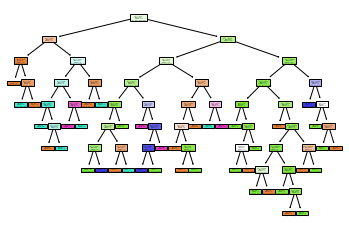

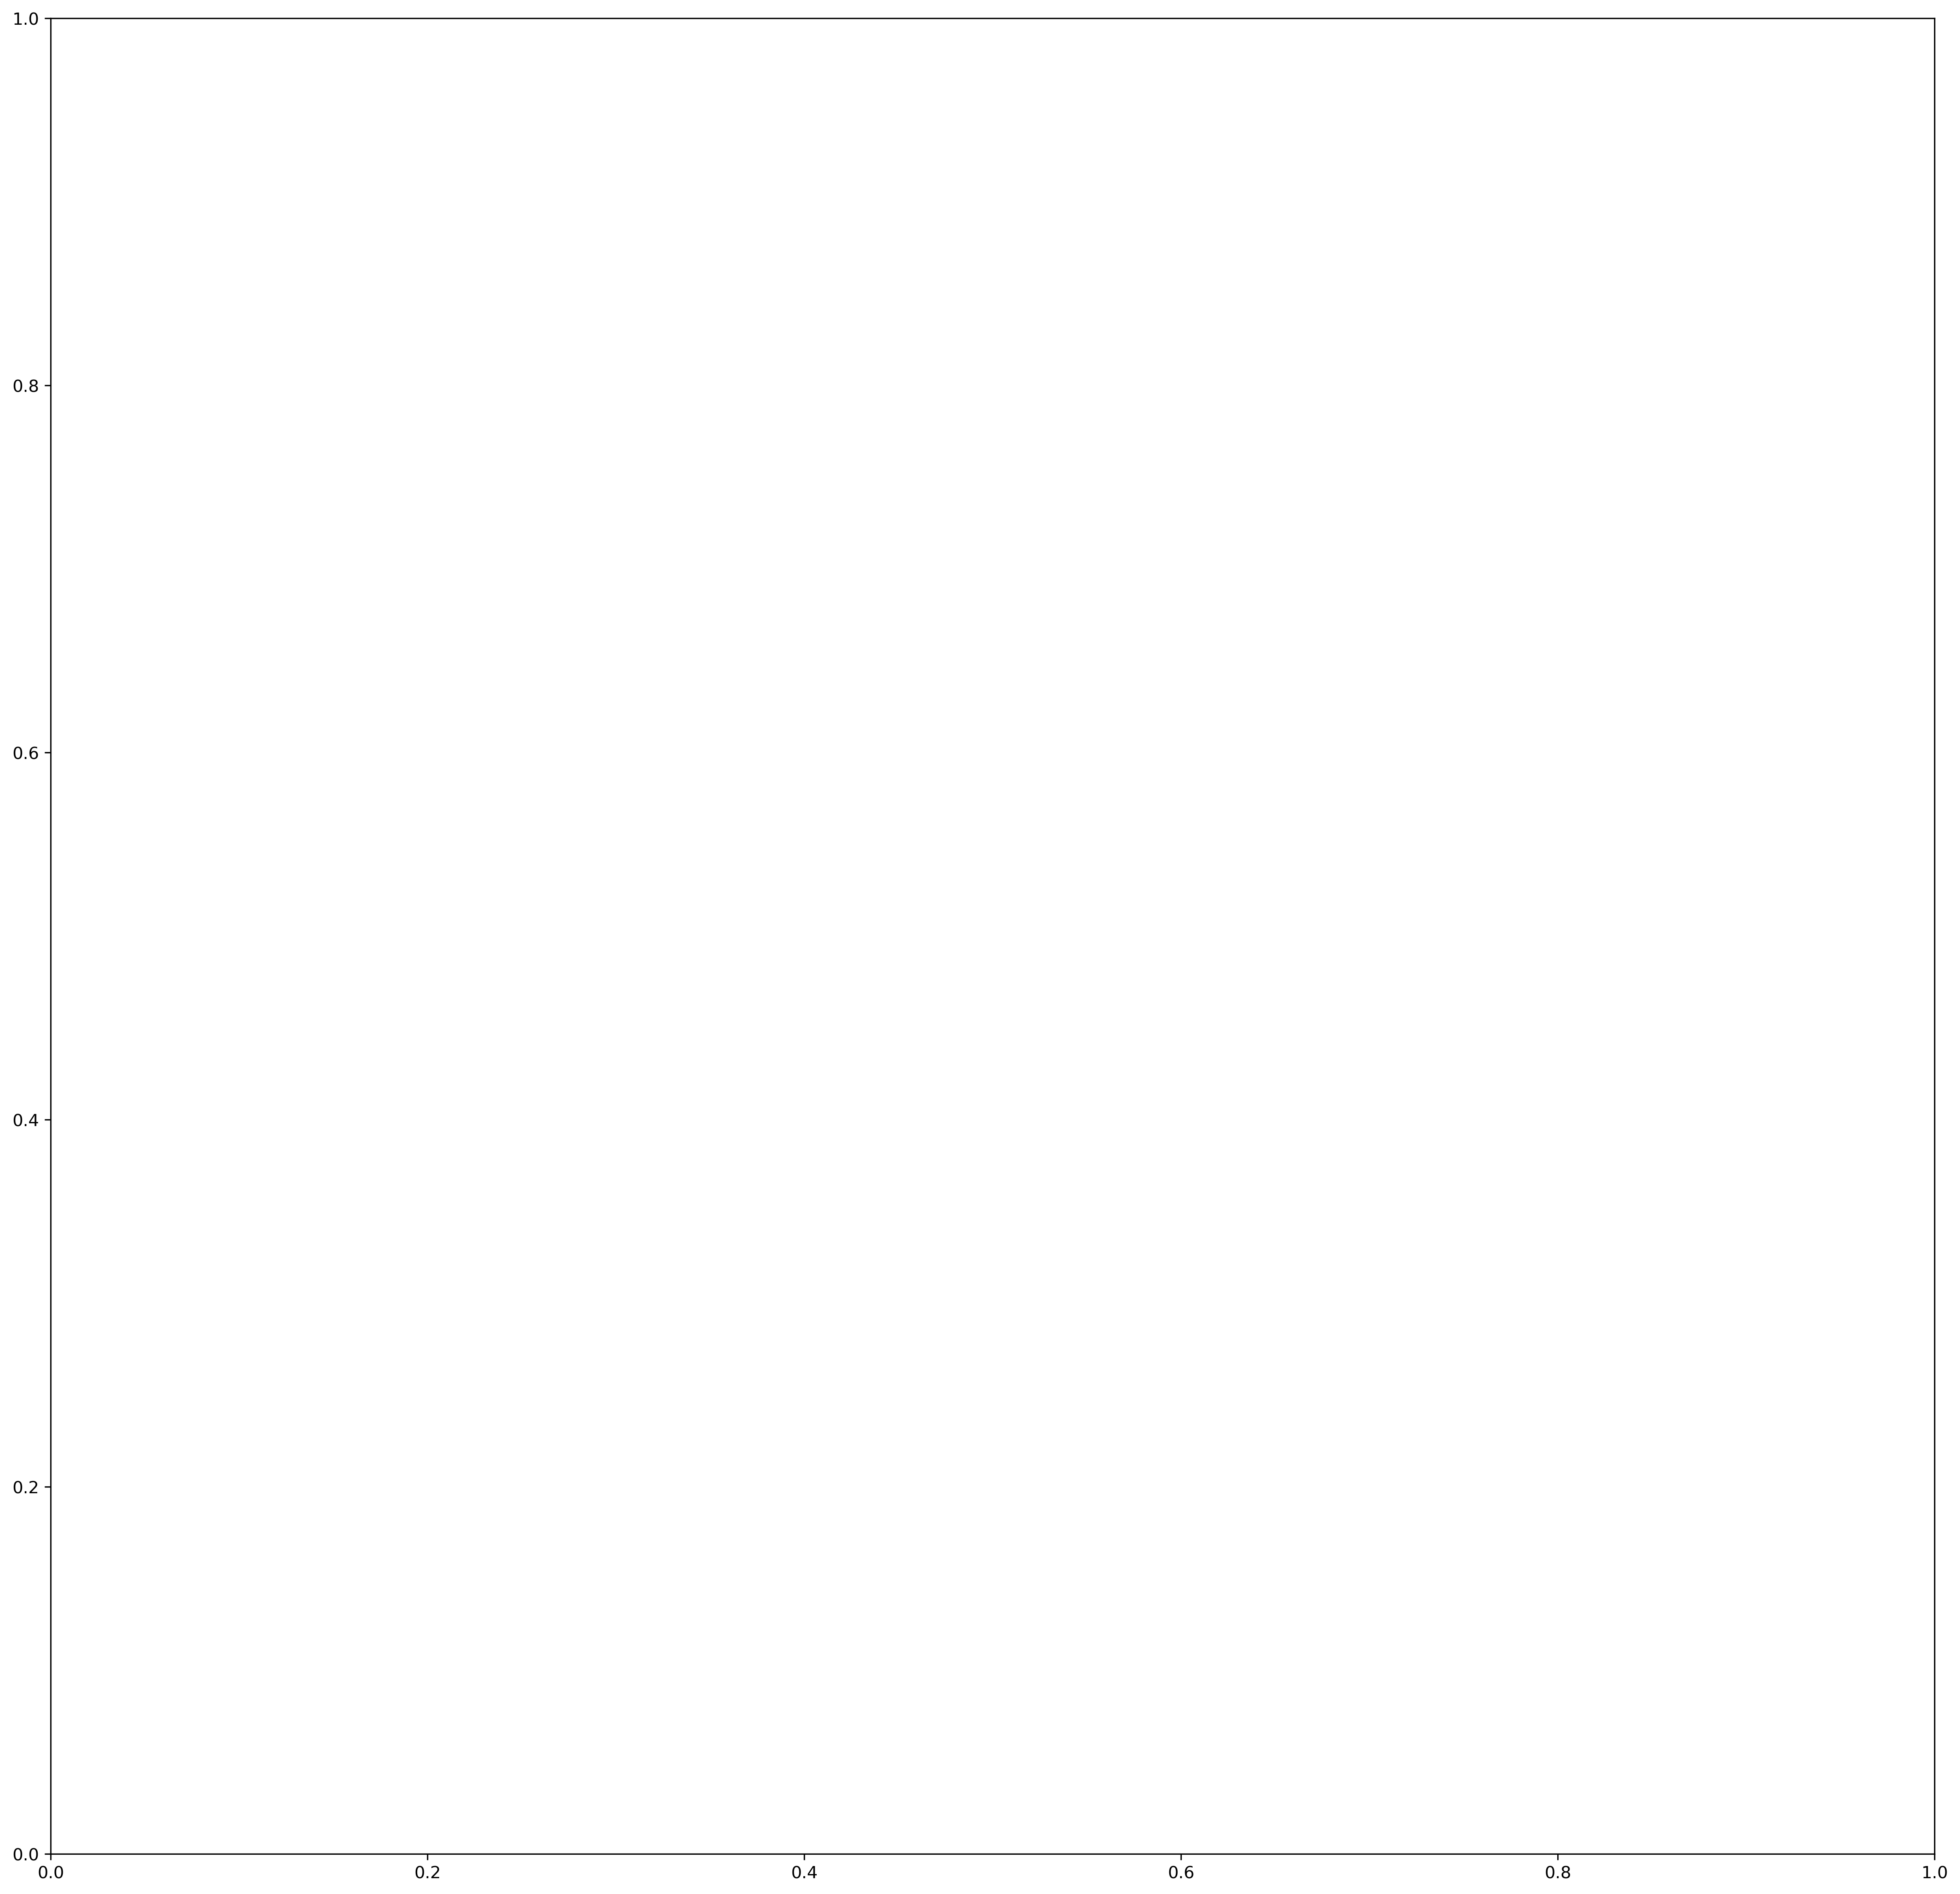

In [21]:
from sklearn import tree
tree.plot_tree(dt_model,filled = True)
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=300)
fig.savefig('imagename.png')

In [22]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [23]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(rf_model.estimators_[99], 
                           feature_names=wine.feature_names,
                           class_names=wine.target_names, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

NameError: name 'wine' is not defined